# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
#Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [2]:
!ls

HW11_1_aaw329.ipynb  MTA_Fare2.npy  MTA_Fare.npy  MTA_Fare_py3.npy


In [3]:
mta = np.load("MTA_Fare.npy")

In [4]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [5]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [6]:
# The dataset begins on a Friday, so using "W-FRI" will make sure weeks begin on Fridays
dates = pd.date_range(start="2010/05/21", periods=194, freq="W-FRI")

# Note that the given time range is from 2010/05/21 to 2014/02/21
# As you can see, that produces 2 more weeks than the number of weeks given in the dataset
# Therefore, we should probably assume some inaccuracy +- 2 weeks or so
len(pd.date_range(start="2010/05/21", end="2014/02/21", freq="W"))

196

In [7]:
# Find values that are set to -1
np.where(mta == -1)

(array([  0,   0,   0, ..., 599, 599, 599]),
 array([ 0,  0,  1, ..., 22, 22, 22]),
 array([128, 129, 128, ..., 191, 192, 193]))

In [8]:
mta[0,0,128]  # 

-1

In [9]:
# Convert to float ndarray so we can use NaN-aware functions
mtaf = mta.astype(float)

# Need to is np.isnan since equality (==) doesn't work with NaNs
print("nancount is %s" % np.size(np.where(np.isnan(mtaf))))  
mtaf[mtaf == -1] = np.nan
neg_ones = np.where(mtaf == -1.0)
if np.size(neg_ones) == 0:
    print("There are no more -1 values in the array")
print("nancount is %s" % np.size(np.where(np.isnan(mtaf))))

nancount is 0
There are no more -1 values in the array
nancount is 1948689


In [10]:
dates.shape

(194,)

In [11]:
mtaf[0,0,:].shape

(194,)

In [12]:
mtaf.shape[1]

23

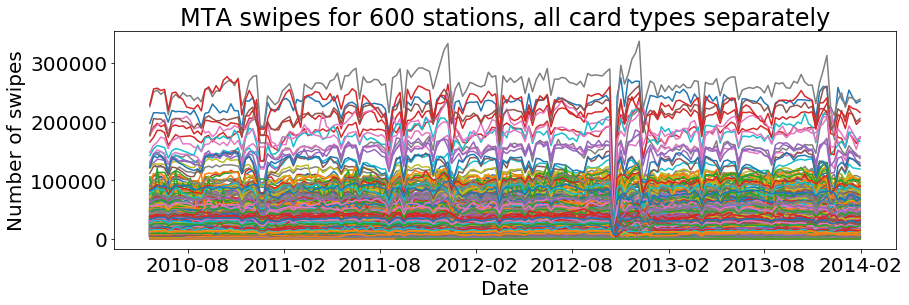

In [13]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)
fig = plt.figure(figsize=(14,4))
ax = fig.subplots()
ax.set_title("MTA swipes for 600 stations, all card types separately")
ax.set_xlabel("Date")
ax.set_ylabel("Number of swipes")

for i in range(mtaf.shape[0]):
    for j in range(mtaf.shape[1]):
        plt.plot(dates, mtaf[i,j,:])



#### Figure 1: time series for every station and every card type as its own plotted line for 194 weeks, starting on 2010/05/21.

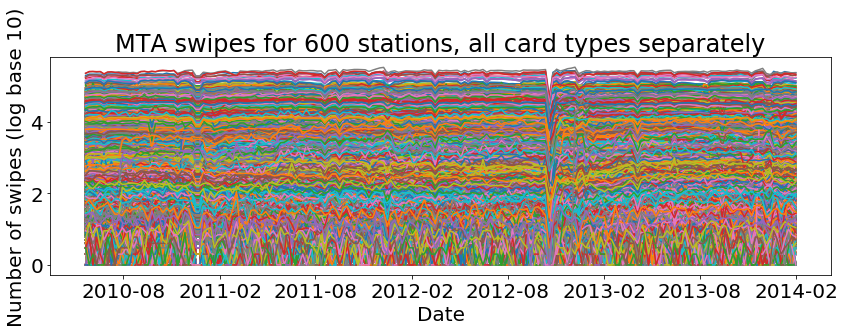

In [14]:
fig = plt.figure(figsize=(14,4))
ax = fig.subplots()
ax.set_title("MTA swipes for 600 stations, all card types separately")
ax.set_xlabel("Date")
ax.set_ylabel("Number of swipes (log base 10)")

#plt.plot(dates, np.log10(mtaf[0,1,:]))
for i in range(mtaf.shape[0]):
    for j in range(mtaf.shape[1]):
        plt.plot(dates, np.log10(mtaf[i,j,:]))


#### Figure 2: time series for every station and every card type as its own plotted line for 194 weeks, starting on 2010/05/21, with the x-axis in log-scale.

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [15]:
def is_nan_array(array):
    """Return True if the array only has NaNs
    Otherwise, return False"""
    for item in array:
        if not np.isnan(item):
            return False
    return True
        
    
def find_eventful_week(data):
    """Return the week that has the most values exceeding a defined threshold
    in terms of standard deviations (sigma)"""
    exceeds = np.zeros(194, dtype=int)
    threshold = 3  # sigma
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            
            series = data[i,j,:]
            if series.shape != (194,):
                print(series.shape)
                return
            
            # Skip arrays containing only NaNs
            # They'll result in warnings from np.nanmean and np.nanstd
            if is_nan_array(series):
                continue  

            mean = np.nanmean(series)
            std = np.nanstd(series)
            
            for k,v in enumerate(series):
                if np.abs(v - mean) > (3 * std):
                    exceeds[k] += 1
                    
    return dates[np.argmax(exceeds)]


find_eventful_week(mtaf)

Timestamp('2012-10-19 00:00:00', offset='W-FRI')

The week shown in the above cell, that of October 19th, 2012, is the week that had the greatest number of series that were more than 3 standard deviations from the mean for that series. This roughly coincides with the week before Hurricane Sandy hit New York City on October 29th of that year (see https://en.wikipedia.org/wiki/Portal:Current_events/October_2012). Here's a [CNN article](http://news.blogs.cnn.com/2012/10/28/sandy-bringing-life-threatening-storm-surge/?hpt=hp_t1) that shows a photo of the empty Times Square subway station before the storm on the 28th.

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [16]:
mtaf.shape

(600, 23, 194)

In [17]:
# Create new ndarray with average over all stations per card type
# np.nanmean prints a warning if it tries to average an entirely NaN-containing array, but this should be fine
avg_per_ctype = np.ndarray((23, 194), dtype=float)
for i in range(23):
    avg_per_ctype[i,:] = np.nanmean(mtaf[:,i,:], axis=0)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Text(0,0.5,'Average swipes (log base 10)')

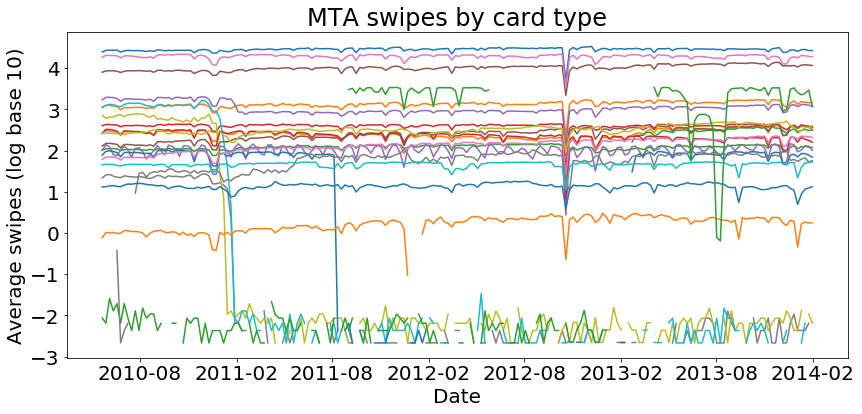

In [18]:
fig = plt.figure(figsize=(14,6))
ax = fig.subplots()
for i in range(23):
    plt.plot(dates, np.log10(avg_per_ctype[i,:]))
    
ax.set_title("MTA swipes by card type")
ax.set_xlabel("Date")
ax.set_ylabel("Average swipes (log base 10)")

#### Figure 3: time series for each card type, with lines representing the average number of swipes across all 600 stations. 

In [19]:
pd.rolling_mean(avg_per_ctype[20,:], window=20, center=True).shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


(194,)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


Text(0,0.5,'Average swipes (log base 10)')

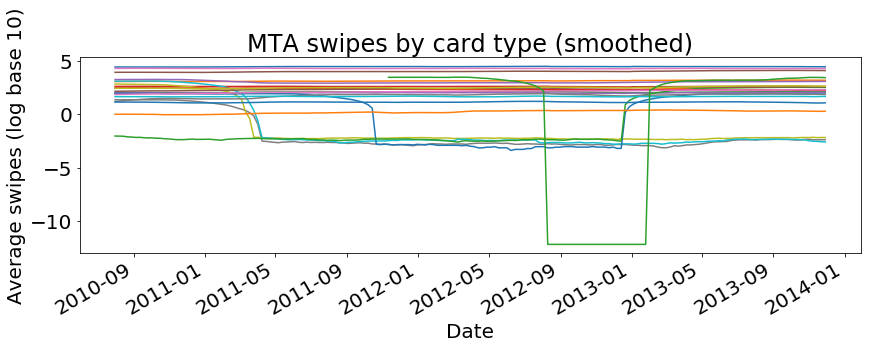

In [20]:
fig = plt.figure(figsize=(14,4))
ax = fig.subplots()

for i in range(23):
    plt.plot(dates, np.log10(pd.rolling_mean(avg_per_ctype[i,:], window=20, center=True)))
    
fig.autofmt_xdate()  # Rotate the x-axis dates to fit a little better

ax.set_title("MTA swipes by card type (smoothed)")
ax.set_xlabel("Date")
ax.set_ylabel("Average swipes (log base 10)")

#### Figure 4: time series for each card type, with lines representing the average number of swipes across all 600 stations. A rolling mean smoothing function has been applied to smooth out the data.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


Card type: ez
Ratio:     0.000004
Card type: exp
Ratio:     0.000010
Card type: afas
Ratio:     0.000178
Card type: rfm
Ratio:     0.616936
Card type: month
Ratio:     0.638787


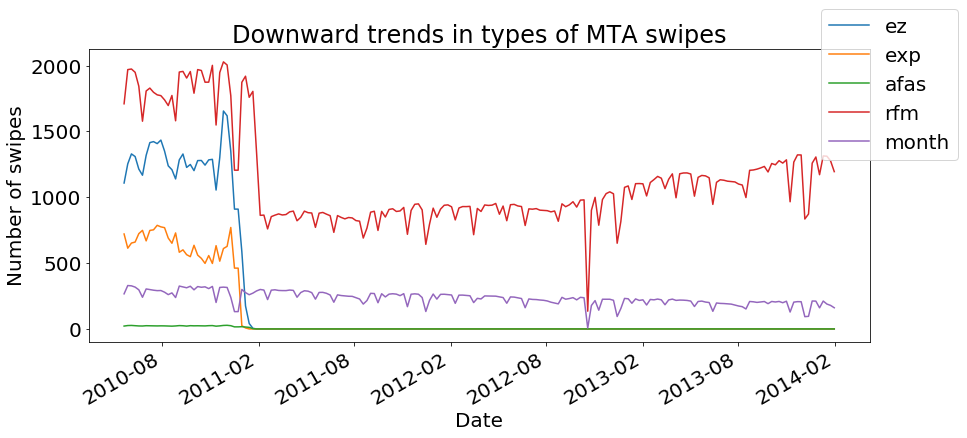

In [21]:
trend_ratio = np.zeros((23, 2))
for i in range(23):
    
    rm = pd.rolling_mean(avg_per_ctype[i,:], window=20)
    start, end = rm[20], rm[-20]
    
    trend_ratio[i,0] = end / start
    trend_ratio[i,1] = i
    #print("Card type: %s" % ridetype[i])
    #print("Ratio:     %f" % trend_ratio[i])
    
#print(trend_ratio)
#print(np.argsort(trend_ratio[:,0]))
trend_ratio = trend_ratio[trend_ratio[:,0].argsort()]
#print(trend_ratio)

fig = plt.figure(figsize=(14,6))
ax = fig.subplots()

# Print 5 series with smallest trend ratio
for i in range(5):
    index = int(trend_ratio[i,1])
    print("Card type: %s" % ridetype[index])
    print("Ratio:     %f" % trend_ratio[i,0])
    plt.plot(dates, avg_per_ctype[index,:], label=ridetype[index])
    
ax.set_title("Downward trends in types of MTA swipes")
ax.set_ylabel("Number of swipes")
ax.set_xlabel("Date")
fig.legend()
fig.autofmt_xdate()

#### Figure 5: time series for each of the 5 biggest downward trends. Downward trends were found by taking a rolling mean near the beginning and end of the time series for each MTA card type, and sorting by the ratio of these two means. The two most visually smooth trends shown on this graph are those for "rfm" (reduced fare) and "month" (monthly). Of those two rfm has the smallest ratio.

Card type: stud
Ratio:     nan
Card type: mr
Ratio:     33264.157058
Card type: spec
Ratio:     4.907598
Card type: sen
Ratio:     2.557834
Card type: rr
Ratio:     2.358447


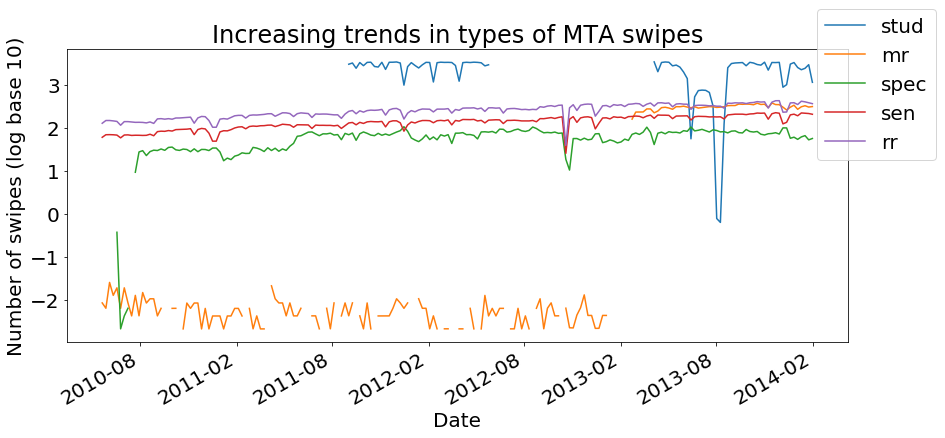

In [22]:
fig = plt.figure(figsize=(14,6))
ax = fig.subplots()

# Print 5 series with largest trend ratio
for i in range(22, 22 - 5, -1):
    index = int(trend_ratio[i,1])
    print("Card type: %s" % ridetype[index])
    print("Ratio:     %f" % trend_ratio[i,0])
    plt.plot(dates, np.log10(avg_per_ctype[index,:]), label=ridetype[index])
    
ax.set_title("Increasing trends in types of MTA swipes")
ax.set_ylabel("Number of swipes (log base 10)")
ax.set_xlabel("Date")
fig.legend()
fig.autofmt_xdate()

#### Figure 6: time series for each of the 5 most increasing trends. Increasing trends were found in the same way as decreasing trends. That is, by taking a rolling mean near the beginning and end of the time series for each MTA card type, and sorting by the ratio of these two means. The three visually smooth trends shown on this graph are those for "spec" (special), "sen" (senior citizen), and "rr" (rail road). Of these three, spec has the highest increasing trend ratio.

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [23]:
mtaf.shape

(600, 23, 194)

In [24]:
labels = np.tile(np.arange(23), 600)
labels.shape

(13800,)

In [25]:
station_ids = np.repeat(np.arange(600), 23)
station_ids.shape

(13800,)

In [26]:
mtaf_test = mtaf

mtaf_test = mtaf_test.reshape(600 * 23, 194)

to_delete = []
for i in range(600 * 23):
    if np.isnan(mtaf_test[i,:]).any():
        to_delete.append(i)
            

In [27]:
mtaf_test.shape

(13800, 194)

In [28]:
# Delete in reverse since each deletion will mess up 
# all indices greater than the deleted index
for index in reversed(to_delete):  
    mtaf_test = np.delete(mtaf_test, index, 0)
    labels = np.delete(labels, index, 0)
    station_ids = np.delete(station_ids, index, 0)

In [29]:
mta_series = mtaf_test

In [30]:
mta_series.shape

(9174, 194)

In [31]:
labels.shape

(9174,)

In [32]:
station_ids.shape

(9174,)

In [33]:
series_means = np.zeros(9174, dtype=float)
for i,s in enumerate(mta_series):
    series_means[i] = s.mean()
series_means.shape

(9174,)

In [34]:
series_stds = np.zeros(9174, dtype=float)
for i,s in enumerate(mta_series):
    series_stds[i] = s.std()
series_stds.shape

(9174,)

In [35]:
station_means = np.zeros(600, dtype=float)
station_stds = np.zeros(600, dtype=float)

In [36]:
# Calculate mean and standard deviation for all series pertaining to each station
for i in range(600):
    all_station_series = None
    for j in range(9174):
        if station_ids[j] == i:
            if all_station_series is None:
                all_station_series = mta_series[j]
            else:
                all_station_series = np.concatenate([all_station_series, mta_series[j]])
    if all_station_series is None:  # Some stations do not have any valid series (without any NaNs)
        station_means[i] = np.nan
        station_stds[i] = np.nan
    else:
        station_means[i] = all_station_series.mean()
        station_stds[i] = all_station_series.std()

In [37]:
station_means.shape

(600,)

In [38]:
station_stds.shape

(600,)

In [39]:
normed_time_series_means = np.zeros(9174, dtype=float)
normed_time_series_stds = np.zeros(9174, dtype=float)

normed_time_series_means = series_means
for i in range(9174):
    normed_time_series_means[i] /= station_means[station_ids[i]]

normed_time_series_stds = series_stds
for i in range(9174):
    normed_time_series_stds[i] /= station_stds[station_ids[i]]

print(normed_time_series_means.shape)
print(normed_time_series_stds.shape)

(9174,)
(9174,)


In [40]:
normed_time_series_stds[:10]

array([ 0.46949484,  0.05230022,  0.00976068,  0.01176713,  0.00508036,
        0.34331495,  0.21873513,  0.00147165,  0.01333437,  0.08054435])

In [41]:
series_means[:10]

array([  1.12706468e+01,   4.59181168e-01,   5.69679310e-02,
         9.60924583e-02,   9.19999345e-03,   5.48353987e+00,
         3.99749538e+00,   1.22775713e-03,   1.47003454e-02,
         9.54703947e-02])

In [42]:
series_stds[:10]

array([ 0.46949484,  0.05230022,  0.00976068,  0.01176713,  0.00508036,
        0.34331495,  0.21873513,  0.00147165,  0.01333437,  0.08054435])

In [43]:
standardized_series = np.ndarray((9174, 194))
for i in range(9174):
    standardized_series[i] = (mta_series[i] - series_means[i]) / series_stds[i]
series_stds[10]

0.0022168108709801617

Text(0,0.5,'standardized number of rides')

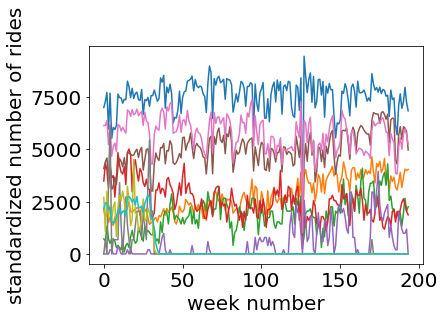

In [44]:
for i in range(10):
    pl.plot(standardized_series[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [45]:
allfits = [sm.OLS(standardized_series[i], np.array([np.arange(194), np.ones(194)]).transpose()).fit() 
           for i in range(9174) 
           if not np.isnan(standardized_series[i]).any()]

In [46]:
[a.params[0] for a in allfits[:10]]

[0.081349617571364941,
 12.567393975954033,
 9.2356679435243443,
 -9.219354052339277,
 8.8409922968473396,
 7.5277507682799802,
 -4.9411332437023372,
 -6.4524347370173913,
 -9.0247062156323139,
 -9.5338104754036568]

In [47]:
[a.params[1] for a in allfits[:10]]

[7527.1566356117855,
 1543.0367700191002,
 940.7181240373551,
 3452.8790758399246,
 -284.74966115624039,
 4286.9901915678674,
 6213.161790412606,
 884.52297543253087,
 1216.9197616040872,
 1292.0609801780322]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [48]:
np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              series_means / normed_time_series_stds, series_stds / normed_time_series_stds]).T.shape

(4,)

In [49]:
for i in [[a.params[0] for a in allfits], 
              [a.params[1] for a in allfits], 
              [(series_means / normed_time_series_stds)[i] 
               for i in range(9174) 
               if not np.isnan(standardized_series[i]).any()], 
              [(series_stds / normed_time_series_stds)[i] 
               for i in range(9174) 
               if not np.isnan(standardized_series[i]).any()]]:
    print(len(i))

7660
7660
7660
7660


In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], 
              [a.params[1] for a in allfits], 
              [(series_means / normed_time_series_stds)[i]   # A bunch of list comprehensions to make everything consistently-sized
               for i in range(9174) 
               if not np.isnan(standardized_series[i]).any()], 
              [(series_stds / normed_time_series_stds)[i] 
               for i in range(9174) 
               if not np.isnan(standardized_series[i]).any()]]).T, 
    [labels[i] 
     for i in range(9174)
     if not np.isnan(standardized_series[i]).any()], test_size=0.33, random_state=42)

In [51]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((5132, 4), (2528, 4), (5132,), (2528,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [52]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

In [54]:
clf = rfc().fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.46242088607594939

and use sklearn confusion_matrix to see the errors

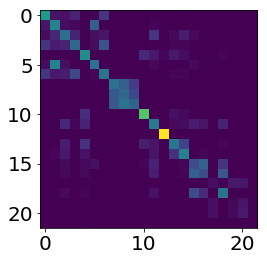

In [55]:
plt.imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

In [56]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.55      0.59      0.57       135
        14d       0.36      0.50      0.42       133
         1d       0.36      0.36      0.36       148
         2t       0.41      0.33      0.37       147
        30d       0.50      0.59      0.54       124
         7d       0.45      0.38      0.41       144
        ada       0.44      0.40      0.42       142
       afas       0.40      0.44      0.42       126
        exp       0.33      0.40      0.36       125
         ez       0.44      0.33      0.38       143
         ff       0.77      0.79      0.78       137
         mc       0.40      0.43      0.41       138
         mr       0.97      0.99      0.98       149
      month       0.54      0.40      0.46       146
        rfm       0.50      0.55      0.52       119
         rr       0.25      0.25      0.25       138
        sen       0.30      0.24      0.27       142
       spec       0.30      0.21      0.24   

In [57]:
clf.feature_importances_

array([ 0.2869326 ,  0.28412574,  0.42894167,  0.        ])

## Build a model that uses as input features each time stamp (194 features) :


In [58]:
mta_series.shape

(9174, 194)

In [59]:
labels.shape

(9174,)

In [60]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(mta_series, labels, test_size=0.33, random_state=42)

In [61]:
clf = rfc().fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.69649933949801845

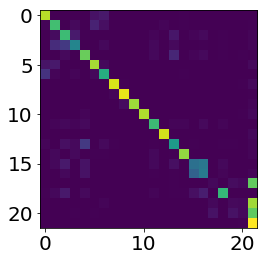

In [62]:
plt.imshow(confusion_matrix(y_test, y_pred))

In [63]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.79      0.88      0.83       151
        14d       0.69      0.78      0.73       134
         1d       0.63      0.73      0.68       139
         2t       0.71      0.54      0.61       126
        30d       0.70      0.79      0.74       146
         7d       0.83      0.84      0.83       154
        ada       0.76      0.76      0.76       123
       afas       0.98      0.96      0.97       146
        exp       0.96      0.98      0.97       147
         ez       1.00      0.95      0.97       134
         ff       1.00      0.96      0.98       137
         mc       0.85      0.83      0.84       123
         mr       0.99      0.98      0.98       142
      month       0.67      0.63      0.65       130
        rfm       0.95      0.89      0.92       140
         rr       0.49      0.38      0.42       146
        sen       0.42      0.50      0.46       125
       spec       0.23      0.02      0.04   

In [64]:
clf.feature_importances_

array([ 0.0123598 ,  0.00791118,  0.00672201,  0.00873519,  0.01395834,
        0.00346411,  0.01442632,  0.00757698,  0.01024452,  0.01207559,
        0.01237683,  0.00975647,  0.00443478,  0.0052503 ,  0.00513757,
        0.00455958,  0.00821343,  0.0037802 ,  0.02110216,  0.00402648,
        0.0256554 ,  0.0098219 ,  0.00977606,  0.00807458,  0.00983012,
        0.01121016,  0.00692801,  0.00706321,  0.00472464,  0.00756775,
        0.00899325,  0.00806338,  0.01459543,  0.01300522,  0.01572364,
        0.00883761,  0.00887213,  0.00289569,  0.00508111,  0.0076266 ,
        0.00593322,  0.00228708,  0.00873292,  0.00244453,  0.00373764,
        0.00719991,  0.00178946,  0.00156373,  0.0022078 ,  0.00282648,
        0.0067757 ,  0.00254706,  0.01086149,  0.00066688,  0.00304073,
        0.00136188,  0.00771803,  0.00148826,  0.00227346,  0.00191017,
        0.00177402,  0.00175229,  0.00181044,  0.00165901,  0.00177298,
        0.00326311,  0.00749529,  0.00609187,  0.00165473,  0.00

As can be seen from the models' respective confusion matrices and score, the model using all time series values as 194 parameters achieved greater accuracy than the model using our "engineered" features.